In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import pickle

from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

from scipy.stats import pearsonr as pr
from scipy.stats import spearmanr as sr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE

### 1. validation and test loss 

In [2]:
def plot_scores(infile,ylim,ylabel,metric,outname=None):
    data = pickle.load(open(infile,'rb'))
    
    plt.figure(figsize=(5,3))
    
    
    xticks = [tick for tick in data['xticks'] if not str(tick).startswith('RESRed')]
    cs = ['#fc8d59' if 'RESRed' in str(tick) else '#1f78b4'for tick in xticks]
    pos = np.arange(len(cs))
    y = [data[metric].get(tick,0) for tick in xticks]
    print(y)
    plt.bar(pos,y,color=cs)
    plt.xticks(pos,xticks,rotation=45,ha='right')
    
    rg = ylim[1]-ylim[0]
    for i, r2 in enumerate(y):
        if r2 == 0: continue
        if r2<ylim[0]: r2=ylim[0]
        if r2<ylim[1]: plt.text(pos[i],r2+rg*0.01,'{0:.2f}'.format(y[i]),ha='center')
        else: plt.text(pos[i],ylim[0]+rg*0.9,'{0:.2f}'.format(y[i]),ha='center')
    plt.ylim(ylim)
    plt.ylabel(ylabel)
    plt.xticks(pos,xticks,rotation=90)
    if outname is not None: plt.savefig(outname,bbox_inches='tight')
    plt.show()

[0.17317917571470498, 0.28120658948178584, 0, -9.344149788660168, 0.3663079878573337, 0, 0.5378328381211125]


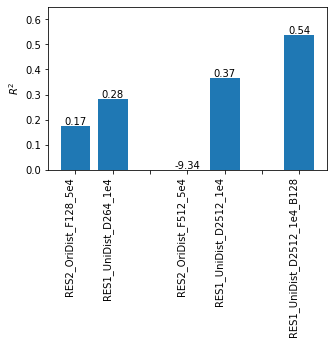

In [3]:
plot_scores('../results/pre_train_on_ogt_dataset/pretrain_on_ogt_val_loss.pkl',
            ylim=[0,0.65],
            ylabel='$R^2$',
            metric='r2_score',
            outname='../results/figures/ogt_val_r2_diff_models.pdf')

[7.773719669269414, 7.004319640680541, 0, 23.252230428779846, 6.667279324033949, 0, 6.091496336786073]


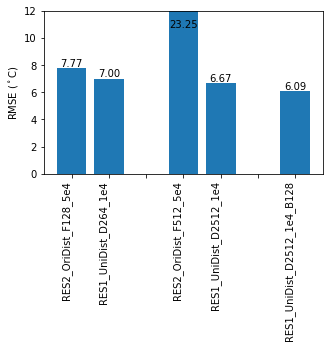

In [4]:
plot_scores('../results/pre_train_on_ogt_dataset/pretrain_on_ogt_val_loss.pkl',
            ylim=[0,12],
            ylabel='RMSE ($^\circ$C)',
            metric='rmse',
            outname='../results/figures/ogt_val_rmse_diff_models.pdf')

[-0.28768881759390297, 0.37858551374344473, 0, -17.594446715655916, 0.4914854294825506, 0, 0.5886556000686585]


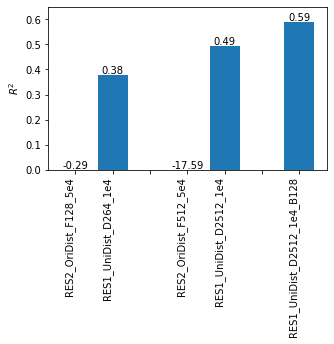

In [5]:
plot_scores('../results/pre_train_on_ogt_dataset/pretrain_on_ogt_test_loss.pkl',
            ylim=[0,0.65],
            ylabel='$R^2$',
            metric='r2_score',
            outname='../results/figures/ogt_test_r2_diff_models.pdf')

[9.695135051042154, 6.735023067941436, 0, 36.8417313287136, 6.092564022966192, 0, 5.479629505968814]


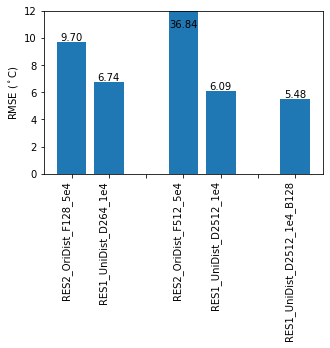

In [6]:
plot_scores('../results/pre_train_on_ogt_dataset/pretrain_on_ogt_test_loss.pkl',
            ylim=[0,12],
            ylabel='RMSE ($^\circ$C)',
            metric='rmse',
            outname='../results/figures/ogt_test_rmse_diff_models.pdf')

### 2. scatter plot of predicted ogt of test

In [9]:
def density_scatter( x , y,  sort = True, bins = 30, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """

    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    plt.scatter( x, y, c=z, **kwargs, s=0.1,zorder=1)

In [12]:
def plot_scatter_comparison_between_predicted_true_ogt_test():
    data = pickle.load(open('../results/pre_train_on_ogt_dataset/pretrain_on_ogt_test_loss.pkl','rb'))
    pred_type1 = data['ogt_predicted']['RES1_UniDist_D2512_1e4_B128']
    pred_type2 = data['ogt_predicted']['RESRed_UniDist_D2512_1e4_B128'] 
    
    
    def _plot(x,outname=None):
        y = data['true_ogt']
        
        print('pr:',pr(y,x),pr(y,x)[1]==0)
        print('sr:',sr(y,x))
        print('r2:',r2_score(y,x))
        print('rmse:',np.sqrt(MSE(y,x)))
        
        lim = [0,120]
        
        x = x.ravel()
        y = y.ravel()
        
        plt.figure(figsize=(3.,2.5))
        density_scatter(x,y,bins=20)
        
        plt.plot(lim,lim,zorder=0,color='gray')
        
        plt.xlim(lim)
        plt.ylim(lim)
        
        plt.xlabel('Predicted OGT ($^\circ$C)')
        plt.ylabel('True OGT ($^\circ$C)')
        #plt.tight_layout()
        plt.savefig(outname,dpi=300,bbox_inches='tight')
        plt.show()
    
    _plot(pred_type1,'../results/figures/type1_pred_vs_true_ogt_test.png')
    _plot(pred_type2,'../results/figures/type2_pred_vs_true_ogt_test.png')

pr: (array([0.77289662]), array([0.])) [ True]
sr: SpearmanrResult(correlation=0.6295234440171489, pvalue=0.0)
r2: 0.5886556000686209
rmse: 5.479629505969062


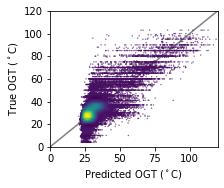

pr: (array([0.74028769]), array([0.])) [ True]
sr: SpearmanrResult(correlation=0.5916689158085732, pvalue=0.0)
r2: 0.5405260515953488
rmse: 5.791337130206204


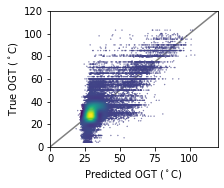

In [13]:
plot_scatter_comparison_between_predicted_true_ogt_test()